(chap:hst-data)=
# Retrieving Optical Images from the HLA

There are two ways to retrieve data from the HLA. The first is manually, and the second requires you to query the HLA from within `python`. The benefit to the latter technique is that this makes data retrieval practically automatic, although it does require a lot of user input that may take longer than it's worth, depending on your workflow. It also allows you to pull data directly from from archive without having to download it to your computer, which is an enormous memory saver! However, with the way I've written my query, I've found it may not capture all *HST* images available on the HLA. I haven't figured out how to solve for that issue quite yet. The only solution I have for now is to double-check everything with the manual process, and download any data that may be missing from the automatic query onto your computer to incorporate into your workflow. 

First, I will demonstrate the  manual way to retrieve *HST* data. Then, I will give my new code for automatic data retrieval. Again, use the latter with caution, as it takes a long time and doesn't always return all of the data available! 

```{note}
If you intend to make a mosaic, this step is not necessary. Instead, I would recommend using the HLA to identify proposal IDs for the images that you want to use, then skip ahead to the `AstroDrizzle` step!
```

(sec:HLA-search)=
## HLA Image Search (Manual)

To pull images from the HLA, [go to the website](https://hla.stsci.edu) and type in the name of your galaxy. If the galaxy has been observed with *HST*, a list of observations will appear under the `Inventory` tab. For my research, I require observations using the WCF3/UVIS[^1] or ACS/WFC[^2] detectors. I narrow down the observations by specifying the detector under the `Detector` tab (to my knowledge, this can only be done one at a time). 

```{figure} hla.png
:name: fig-hla

Example search using the Hubble Legacy Archive.
```

It's useful to view what the actual images look like before downloading them. To do this, switch from the `Inventory` tab to the `Images` tab. Select the appropriate images (you'll more than likely want the ones with science data) and add them to your cart by clicking the `Download Data: FITS-Science` link beneath each image.  This will add them to the shopping cart tab, which you can use to retrieve your FITS data files once all desired images are selected.

(sec:pyvo-search)=
## `python` HLA query with `PyVO`

The code that I use for querying the HLA through `python` is included in the script `ImageSearch.py`. This is heavily based on `PyVO`[^3], which you should have already installed during the setup phase, and is mostly useful when you have a small number of sources to analyze.

To use `ImageSearch.FindHST()`, you will need to provide the function with either a list containing the RA and Dec of a single source (in units degrees), or a `DataFrame` containing the coordinates of multiple sources. So, for example, either :
```
FindHST([<RA>, <Dec>], galaxy = <galaxy>, savefile = <file>)
```
or
```
FindHST(<DataFrame>, galaxy = <galaxy>, savefile = <file>)
```

will work, as long as the coordinates, galaxy name, and some output file name are given. In either case, `FindHST()` will search the HLA for any optical image containing the coordinates given and present them as a list -- first searching for ACS/WFC observations, then searching for WFC3/UVIS observations. Upon user request, it will plot the images with the coordinate of the source marked as a red `X` and prompt the user to input the indices of the best image files to save. You will want to select at least one image for each of the filters you're interested in, where applicable. It will then save the image information to a `.csv` file matching your designated `savefile` name. This `.csv` will include a URL that can be used to read in the image file directly from the HLA without having to download the image to your computer! 

If you just want to use `FindHST()` to look for all images associated with the galaxy, not necessarily for each individual XRB, you can do so by providing the coordinates of the galaxy and setting the search radius to the radius of the galaxy, in arcseconds. This will likely return many potential images, so in this case it's recommended to save the initial HLA search using the `savesearch` parameter and decide in conjunction with the HLA website which images are appropriate from that image list. For example:


```
from ImageSearch import FindHST
%run ImageSearch.py

FindHST([210.802368, 54.359667], galaxy='M101', search_rad=900, \
        savefile='Obslog_M101.csv', savesearch='M101_HLAsearch.csv')
        
# This code will produce a table with nearly 200 images. You can choose to go through each one sequentially, 
# or use the M101_HLAsearch.csv + HLA to identify the best images manually
```

On the other hand, if you read in a `DataFrame` instead of a single pair of coordinates, then you will want to only use sources from a single galaxy at a time, and you'll want to have a header containing some form of a source ID, which the code will prompt you to provide (for example, `CSC ID`). Currently, this code can only handle a single galaxy at a time, but this can be fairly easily updated to search for a galaxy header in the `DataFrame` in the future.

The downside of this procedure (as opposed to the manual HLA search) is that if you're reading in a `DataFrame` containing all X-ray sources in a galaxy, then you will need to confirm the appropriate *HST* image for every XRB individually, which can take a lot of time for galaxies with many XRBs. However, you will not need to download the actual `FITS` files to access them, which saves a ton of memory and makes reading in each image faster. This procedure also saves all of the *HST* information about the observation that you could need, which is an added bonus that comes in handy when you're writing a paper on your results! 


(sec:astroquery-search)=
## `python` HLA query with `astroquery`

As an alternative to `PyVO`, one can use `astroquery` to find and download HST data. `PyVO` is still a requirement for `astroquery`, so even if you decide not to use the `PyVO` method above, you'll probably still need to install it. I use `astroquery` in Chapter \ref{chap:astrodriz} as part of my drizzling workflow, as it will find the FLC files needed for the drizzling and mosaic creation for you. For more information, see Chapter \ref{sec:astrodriz-files}.


## Handling *HST* Data
The image data files from *HST* is given in `FITS` format[^4]. This may be read in as an `HDU`[^5] object with some form of `python` code resembling:
```
from astropy.io import fits
hdu = fits.open(<FITS file name>)
hdu.info()
```

The last line of that code will print a name and type of data stored in the `HDU` object, as well as the index you can use to access the data (`No.`). The `PRIMARY` element contains information regarding the image observation and reduction (e.g. the instrument configuration, calibrations applied, exposure time, etc.), and can be accessed with `.header` via `hdu[0].header`, where the index used is the index of the primary data, or `hdu['PRIMARY'].header`. 

Importantly, the image from which the photometry is extracted is (usually) stored under `SCI`. The header information under `SCI` may also contain a lot of good information, including image statistics like the signal-to-noise (if the image reduction team was thorough in their record keeping), so it's a good idea to take a look. Keep in mind, if you choose to create a mosaic and set `build=False` in `AstroDrizzle` (see Chapter \ref{sec:astrodriz}), the science data will be stored under `PRIMARY` rather than under its own extension. 

If you used the automatic HLA search method (`FindHST()`), then you can read in the `FITS` file associated with each source using `ImageSearch.GetFITS()` (Chapter \ref{sec:script-imagesearch}), which requires you provide the name of the file saved by `FindHST()`, the source of interest, the detector (in my case, ACS/WFC or WFC3/UVIS), and the filter (e.g. F814W, F555W, etc). `GetFITS()` reads in the image URL and returns an `HDU` object, so instead of the code above (which you would use if you saved a `FITS` directly to your computer), you can instead use something like:
```
from ImageSearch import GetFITS
%run ImageSearch.py
hdu = GetFITS(infile=<FindHST savefile name>, source_id=<source ID>,
              detector=<'ACS/WFC' or 'WFC3/UVIS'>, filter=<filter>)
```

From the `HDU` object, a monochromatic image can be plotted using `imshow()` from `matplotlib.pyplot`. For these particular data, since light from a galaxy is logarithmic, you will also need to define a normalization parameter, `norm`. I tend to use `matplotlib.colors.Normalize()` with some specified `vmin` and `vmax` to change the scaling until the image looks right. For example:

Filename: M101_acs_wfc_f435w_example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     789   ()      
  1  SCI           1 ImageHDU        86   (5302, 5318)   float32   


None

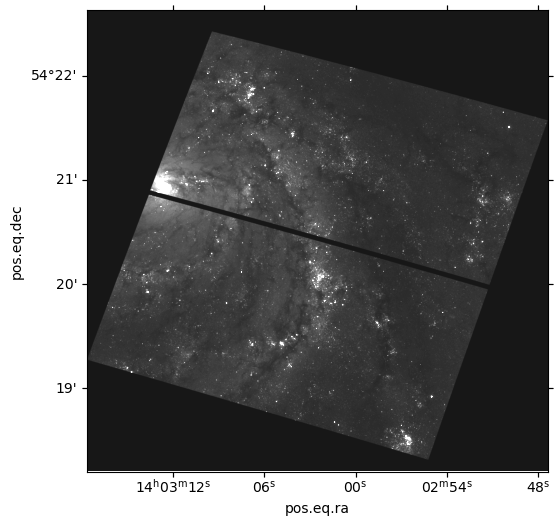

In [55]:
import matplotlib
import matplotlib.pyplot as plt
from astropy.wcs import WCS # defining the coordinate system, e.g. RA/Dec
from astropy.io import fits

hdu = fits.open('M101_acs_wfc_f435w_example.fits')
display(hdu.info()) # Display the hdu info to get more information about what it contains

# Setting up the figure
plt.figure(figsize=(6,6))

# hdu['SCI'].header usually contains info needed to set up the image projection
# But you may need to check your specific hdu file
ax = plt.subplot(projection=WCS(hdu['SCI',1].header))
plt.imshow(hdu['SCI',1].data, cmap="gray", origin="lower",
          norm=matplotlib.colors.Normalize(vmin=-0.05, vmax=.5))
plt.show()

To get a color image, you can use `make_lupton_rgb()` from `astropy.visualization` to generate a scaleable RGB color image, create your own logarithmic scaling algorithm, or simply use either 
`ImageSearch.MakePostage()` or `ImageSearch.PlotField()` from Chapter \ref{sec:script-imagesearch} (which does basically the same, but is a semi-automatic plotting function that will lead you through each of the steps). Below is an example of creating a color image using a custom logarithmic scaling algorithm, which is my preferred method: 

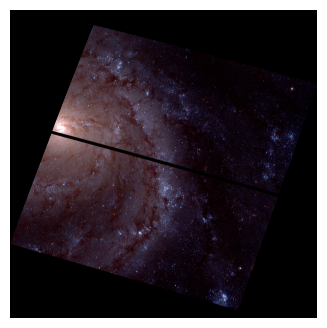

In [51]:
import numpy as np
from reproject import reproject_interp    # May need to install first

# Calling FITS files as the RGB filters
hdu_r = fits.open('M101_acs_wfc_f814w_example.fits')
hdu_g = fits.open('M101_acs_wfc_f555w_example.fits')
hdu_b = fits.open('M101_acs_wfc_f435w_example.fits')
data_g = hdu_g['SCI'].data   # Pulling data from FITS HDU

# Resizing images that don't match the base HDU, hdu_g (required)
if hdu_r['SCI'].data.shape != hdu_g['SCI'].data.shape:
  data_r, _ = reproject_interp(hdu_r['SCI'], hdu_g['SCI'].header)
else: data_r = hdu_r['SCI'].data
if hdu_b['SCI'].data.shape != hdu_g['SCI'].data.shape:
  data_b, _ = reproject_interp(hdu_b['SCI'], hdu_g['SCI'].header)
else: data_b = hdu_b['SCI'].data

# Defining the min and max brightness cutoff of RGB image, per filter
# These are obtained through trial and error.
clipmin_r = 0.2
clipmax_r = 3.0   
clipmin_g = 0.1
clipmax_g = 2.0   
clipmin_b = 0.05
clipmax_b = 1.0   

# Applying mag clipping and converting data to log
r = np.log10(np.clip(data_r, clipmin_r, clipmax_r))
g = np.log10(np.clip(data_g, clipmin_g, clipmax_g))
b = np.log10(np.clip(data_b, clipmin_b, clipmax_b))

# Rescaling the filters based on their individual min and max values
r_scaled = (r-np.nanmin(r))/(np.nanmax(r)-np.nanmin(r))
g_scaled = (g-np.nanmin(g))/(np.nanmax(g)-np.nanmin(g))
b_scaled = (b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b))
rgb_scaled = np.dstack((r_scaled,g_scaled,b_scaled))

# Plotting RGB image
plt.figure(figsize=(4,4))
ax = plt.subplot(projection=WCS(hdu_g['PRIMARY'].header))
plt.imshow(rgb_scaled)
plt.axis("off")
plt.show()

[^1]: For my research, I focus specifically on wide and medium WCF3/UVIS filters because they have models that I can use for the color-magnitude diagram. More on that in Chapter \ref{chap:cmd}
[^2]: All filters are usable for ACS/WFC, as models for all (including LP) are provided.
[^3]: https://pyvo.readthedocs.io/en/latest/
[^4]: https://heasarc.gsfc.nasa.gov/docs/heasarc/fits_overview.html
[^5]: For more information on `HDU` handling, see the official tutorial here: https://docs.astropy.org/en/latest/io/fits/index.html